In [1]:
#Import statements
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import warnings
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score
from scipy import optimize as op
from sklearn.metrics import accuracy_score, roc_auc_score , roc_curve , auc, classification_report, confusion_matrix, mean_squared_error, explained_variance_score 
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import LabelBinarizer
warnings.filterwarnings('ignore')

In [2]:
#Preprocessing data
def preprocess_hazlenuts():
    initialdata = pd.read_csv("dataset\hazlenuts.txt", delimiter='\t',encoding='latin1', na_values="n/a", index_col = 0)
    hazlenut_data = initialdata.T
    hazlenut_data.columns = ['Length','width', 'thickness', 'surface_area', 'mass', 'compactness', 'hardness', 'shell_top_radius', 'water_content', 'carbohydrate_content', 'variety']
    hazlenut_data.reset_index(inplace=True)
    df = hazlenut_data.drop('index', axis=1)
    df.head()
    return (df, df.iloc[:,-1].unique())

In [3]:
def preprocess_generic(path):
    """
    Generic method to read any other dataset assuming rows and columns are in correct order
    """
    rawdata = pd.read_csv(path, delimiter='\t',encoding='latin1', na_values="n/a", index_col = 0)
    df = hazlenut_data.drop('index', axis=1)
    df.head()
    return (df, df.iloc[:,-1].unique())

In [4]:
#Orgaizing data
df, classDetails = preprocess_hazlenuts()
df.head()

,Length,width,thickness,surface_area,mass,compactness,hardness,shell_top_radius,water_content,carbohydrate_content,variety
0,13.86,13.0995,7.349906812,38.1,1439.55,0.93401,8.78,4.7844,0.048826089,0.167,c_avellana
1,20.53,15.5925,9.565426582,49.89,1623.3,0.96217,5.12,5.2893,0.049521325,0.174,c_americana
2,14.13,12.222,7.182948645,35.43,1412.25,0.90178,13.694,4.8168,0.049594663,0.167,c_avellana
3,15.85,14.724,8.622661318,43.29,1512,0.96261,10.925,4.6296,0.050384315,0.173,c_americana
4,21.11,17.4105,9.680494488,56.25,1698.9,0.98989,11.564,5.3928,0.050905478,0.17,c_cornuta


In [5]:
#Number of Samples
samples = df.shape[0]

#Length of all feature columns
n = len(df.columns) - 1

#Number of Labels/Classes
k = len(classDetails)

In [6]:
#Initializing an array of 1s as X-features and y-labels using numpys based on the sampling size
X = np.ones((samples,n))
y = np.array((samples,1))

In [7]:
#Setting values for X and y with feature values and labels respectively
for i in range(1,n):
    X[:,i] = df.iloc[:,i-1]
    
y = df.iloc[:,-1]

In [8]:
#Using Standard Scaler library Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler() 
scaler.fit(X)
X = scaler.transform(X)

In [9]:
#Implementation of Logistic Regression

#Sigmoid function based on the mathematical formula
def sigmoid(t):
    """
    The logistic Regression is represented by a sigmoid function. Returns probability for a class.
    Parameters:
        t = exponential power which determines the sigmoid function
        input to t would be feature values cross product with theta
    """
    return 1.0 / (1 + np.exp(-t))

#Regularized cost function 
def regularized_cost(theta, X, y, alpha):
    """
    Cost function to determine the performance of a model and represent all values as a single real number.
    Parameters:
        hypothesis = generates values for the sigmoid function for given X
        samples = total number of testing samples
        alpha = represents the learning rate of the algorithm
    """
    hypothesis = sigmoid(X.dot(theta)) 
    cost = (1 / samples) * (-y.T.dot(np.log(hypothesis)) - (1 - y).T.dot(np.log(1 - hypothesis))) + (alpha/(2 * samples)) * np.sum(theta**2)
    return cost

#Regularized gradient function
def regularized_gradient_descend(theta, X, y, alpha):
    """
    Gradient Descend function to find the optimal minimal point
    Parameters:
        m = number of samples
        n = number of feature columns
        theta = vector of zeros
        hypothesis = generates values for a sigmoid function for given X
    """
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    hypothesis = sigmoid(X.dot(theta))
    return ((1 / m) * X.T.dot(hypothesis - y)) + (alpha * theta /m)

#Optimal theta calculation
def logistic_regression(X, y, theta, no_of_iterations, alpha):
    """
    Calculating optimal theta value.
    Parameters:
        no_of_iterations = total number of iterations to calculate the optimal theta value default value is 10000
        alpha = learning rate of the model default value is 0.01
        X = Stadardized feature values
        y = Class Train set
    """
    cost_arr = []
    for i in range(no_of_iterations):
        cost = regularized_cost(theta, X, y, alpha)
        cost = cost.sum(axis = 0)
        new_theta = regularized_gradient_descend(theta, X, y, alpha)
        theta = theta - new_theta  
        cost_arr.append(cost)
    return theta, cost_arr

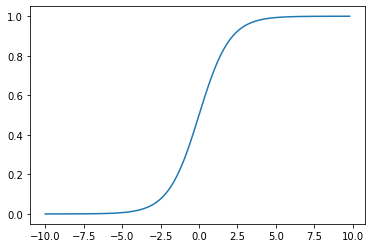

In [10]:
#Plotting Sigmoid 
a = np.arange(-10., 10., 0.2)
re = []
for zz in a:
    sig = sigmoid(zz)
    re.append(sig)
plt.plot(a,re)
plt.show()

In [11]:
def one_versus_all_encoding(classDetails, X_train, y_train, no_of_iterations, alpha):
    """
    Using One vs All encoding to find the optimal theta values for each class 
    """
    all_theta = np.zeros((k, n))
    i = 0
    for variety in classDetails:
        tmp_y = np.array(y_train == variety, dtype = int)
        optTheta, cost = logistic_regression(X_train, tmp_y, np.zeros((n,1)), no_of_iterations, alpha)
        all_theta[i] = optTheta.T
        i += 1
        #print(cost)
    return all_theta

In [12]:
def lr_score_predictions(X_train, X_test, y_train, y_test, no_of_iterations = 10000, alpha = 0.001):
    """
    This method predicts all the probability and returns the accuracy score
    Parameters:
        predictions = Contatins the list of predicted classes
        my_score = accuracy score of my model
    """
    #Optimal theta calculation for all classes
    all_theta = one_versus_all_encoding(classDetails, X_train, y_train, no_of_iterations, alpha)

    #Calculating all probabilities based on the theta values
    all_probabilites = sigmoid(X_test.dot(all_theta.T))

    #Assigning class labels based on the maximum probabilites coefficients calculated
    predictions = [classDetails[np.argmax(all_probabilites[i, :])] for i in range(X_test.shape[0])]
    my_score = accuracy_score(y_test, predictions) * 100
    return predictions, my_score, all_probabilites

In [13]:
def test_lr_cross_validation(iterations=10):
    """
    Method to cross validate the predictions by shuffling the train test split
    Returns best fit for train test split along with the accuracy scores of the constructed model with scikit
    """
    model = linear_model.LogisticRegression(multi_class='auto')
    my_model = []
    scikit_model = []
    for i in range(iterations):
    #Splitting the train and test cases in the ratio of 1/3
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

        predictions, my_score, all_probabilites = lr_score_predictions(X_train, X_test, y_train, y_test)
        #Priting accuracy of the model
        print("My Model Test Accuracy for run ", i+1, " ", my_score , '%')
        my_model.append(my_score)
        if len(my_model) == 1:
            optX_train = X_train
            optX_test = X_test
            opty_train = y_train
            opty_test = y_test
            score = my_model[-1]
        else:
            if my_model[-1] >= max(my_model):
                optX_train = X_train
                optX_test = X_test
                opty_train = y_train
                opty_test = y_test
                score = my_model[-1]
           
        #Scikit learn model fit and predict
        model.fit(X_train,y_train)
        model_prediction = model.predict(X_test)
        scikit_score = accuracy_score(y_test, model_prediction) * 100
        print("Scikit Test Accuracy for run ", i+1, " ", scikit_score , '%')
        scikit_model.append(scikit_score)
    print("My Model Overall Test Accuracy ", statistics.mean(my_model) , '%')
    print("Scikit Model Overall Test Accuracy ", statistics.mean(scikit_model) , '%')
    return optX_train, optX_test, opty_train, opty_test, score, all_probabilites    

In [ ]:
X_train, X_test, y_train, y_test, score, all_probablities = test_lr_cross_validation(10)

My Model Test Accuracy for run  1   92.42424242424242 %
Scikit Test Accuracy for run  1   90.9090909090909 %
My Model Test Accuracy for run  2   96.96969696969697 %
Scikit Test Accuracy for run  2   90.9090909090909 %
My Model Test Accuracy for run  3   95.45454545454545 %
Scikit Test Accuracy for run  3   92.42424242424242 %
My Model Test Accuracy for run  4   95.45454545454545 %
Scikit Test Accuracy for run  4   87.87878787878788 %
My Model Test Accuracy for run  5   96.96969696969697 %
Scikit Test Accuracy for run  5   90.9090909090909 %
My Model Test Accuracy for run  6   95.45454545454545 %
Scikit Test Accuracy for run  6   86.36363636363636 %


In [ ]:
#Best fit test set
predictions, my_score, all_probablities = lr_score_predictions(X_train, X_test, y_train, y_test)

In [ ]:
def createCSV(predictions, y_test):
    """
    Creates a CSV file with actual predictions and model predicted values
    """
    overall=[]
    for i in range(len(predictions)):
        overall.append([predictions[i], y_test.values[i], 'Matched' if predictions[i] == y_test.values[i] else 'Unmatched'])
        Result = pd.DataFrame(overall, columns=["Predicted Values", "Actual Value", "Matched/Unmatched"])
    Result.to_csv('Output.csv', header=True, index=False)

In [ ]:
createCSV(predictions, y_test)

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred , all_probablities, average="macro",classes=k):
    """
    This method returns the ROC score.
    Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    y_test = list(y_test)
    y_pred = list(y_pred)
    label = LabelBinarizer()
    label.fit(y_test)
    y_test = label.transform(y_test)
    y_pred = label.transform(y_pred)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        y_ = [y[i] for y in all_probablities ]
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_)
        roc_auc[i] = auc(fpr[i], tpr[i])
    return roc_auc_score(y_test, y_pred, average=average) , (fpr,tpr,roc_auc)

In [ ]:
def plotting_roc(fpr, tpr, roc):
    """
    This method is used for Plotting ROC for all classes
    Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(k)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(k):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= k
    for i in range(k):
        plt.plot(fpr[i],tpr[i],label='ROC = for %s %s' % (classDetails[i] , roc[i] * 100))
    
    plt.legend(loc="top right")
    plt.show()

In [ ]:
micro_roc , micro_additional_roc  = multiclass_roc_auc_score(y_test, predictions ,all_probablities, average="micro")
roc , additional_roc  = multiclass_roc_auc_score(y_test, predictions ,all_probablities)

In [ ]:
print('Micro Average ROC calculation', micro_roc)
print('Macro Average ROC calculation', roc)
print('Accuracy', my_score)

In [ ]:
print('Classification Report for my model', classification_report(y_test,predictions))

In [ ]:
fpr, tpr, roc = additional_roc
plotting_roc(fpr, tpr, roc)

In [ ]:
cfm = confusion_matrix(y_test, predictions, labels = classDetails)
sns.heatmap(cfm, annot = True, xticklabels = classDetails, yticklabels = classDetails);

In [ ]:
#Plotting ROC for Scikit model
model = linear_model.LogisticRegression(multi_class='auto')
model.fit(X_train,y_train)
model_prediction = model.predict(X_test)
pred = model.predict_proba(X_test)

In [ ]:
micro_scikit_roc , micro_scikit_additional_roc  = multiclass_roc_auc_score(y_test, model_prediction ,pred, average="micro")
scikit_roc , scikit_additional_roc  = multiclass_roc_auc_score(y_test, model_prediction ,pred)

In [ ]:
print('Micro Average ROC calculation', micro_scikit_roc)
print('Macro Average ROC calculation', scikit_roc)
print('Accuracy', accuracy_score(y_test, model_prediction)*100)

In [ ]:
print('Classification Report for scikit model', classification_report(y_test,model_prediction))

In [ ]:
fpr, tpr, roc = scikit_additional_roc
m_fpr, m_tpr, m_roc = micro_scikit_additional_roc
plotting_roc(fpr, tpr, roc)

In [ ]:
cfm = confusion_matrix(y_test, model_prediction, labels = classDetails)
sns.heatmap(cfm, annot = True, xticklabels = classDetails, yticklabels = classDetails);